In [1]:
# Import the cupy library
import cupy as cp

# Create 10,000 random numbers
x = cp.random.rand(10000)
y = cp.random.rand(10000)

# Perform the multiplication of both arrays
result = cp.dot(x, y)

# Print the result
print(result)

2482.740165082818


In [2]:
# Import the corresponding library
import cupy as cp

# Define matrices using CuPy arrays
matrix_a = cp.array([[1, 2], [3, 4]])
matrix_b = cp.array([[5, 6], [7, 8]])

# Perform a matrix multiplication using CuPy
result = cp.matmul(matrix_a, matrix_b)
print("Result of Matrix Multiplication:")
print(result)

Result of Matrix Multiplication:
[[19 22]
 [43 50]]


In [3]:
# Import the corresponding library
import cudf

# Create a GPU DataFrame
data = {'A': [1, 2, 3], 'B': [4, 5, 6]}
df = cudf.DataFrame(data)

# Perform data manipulation
df['C'] = df['A'] + df['B']
print(df)

   A  B  C
0  1  4  5
1  2  5  7
2  3  6  9


In [4]:
# Import the libraries
import pandas as pd
import cudf

# Creating a Pandas DataFrame
pandas_data = {
    'A': [1, 2, 3, 4, 5],
    'B': [10, 20, 30, 40, 50],
    'C': ['a', 'b', 'c', 'd', 'e']
}

pandas_df = pd.DataFrame(pandas_data)

# Display the Pandas DataFrame
print("Pandas DataFrame:")
print(pandas_df)

# Convert Pandas DataFrame to cuDF DataFrame
cudf_df = cudf.DataFrame.from_pandas(pandas_df)

# Display the cuDF DataFrame
print("cuDF DataFrame:")
print(cudf_df)

Pandas DataFrame:
   A   B  C
0  1  10  a
1  2  20  b
2  3  30  c
3  4  40  d
4  5  50  e
cuDF DataFrame:
   A   B  C
0  1  10  a
1  2  20  b
2  3  30  c
3  4  40  d
4  5  50  e


In [5]:
# Import the libraries
from cuml.cluster import KMeans
import cudf

# Generate sample data
data = cudf.DataFrame()
data['feature1'] = cp.random.rand(1000)
data['feature2'] = cp.random.rand(1000)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(data)
labels = kmeans.predict(data)
print(labels)

0      0
1      2
2      2
3      0
4      1
      ..
995    2
996    1
997    1
998    1
999    1
Length: 1000, dtype: int32


In [6]:
# Import the libraries
import pandas as pd
import cudf
import cuml
from cuml.datasets import make_classification
from cuml.model_selection import train_test_split

# Generating a sample Pandas DataFrame
X, y = make_classification(n_samples=1000, n_features=4, n_classes=2, random_state=42)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and fitting a Random Forest Classifier using cuML
rf_classifier = cuml.ensemble.RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred = rf_classifier.predict(X_test)

# Displaying sample predictions
print("Sample predictions:")
print(y_pred[:10])

Sample predictions:
[0. 1. 1. 1. 1. 0. 1. 1. 0. 0.]


In [7]:
import cudf
import cuml
import pyfolio as pf
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.utils import check_random_state

import warnings
warnings.filterwarnings("ignore")

# Obtaining the EURUSD data
data = yf.download('EURUSD=X', start='2000-01-01', end='2024-01-13', auto_adjust=True)

# Initial index number to start forecasting and trading
initial_iloc = data.index.get_loc(data.loc['2019-01'].index[0])

# Drop the volume column
data.drop('Volume', axis=1, inplace=True)

# Set the columns names
columns_names = data.columns.tolist()

# Create the prediction feature
data['y'] = np.where(data['Close'].pct_change().shift(-1) > 0,1, np.where(data['Close'].pct_change().shift(-1) < 0, -1, np.nan))

# Create the input features
for j in range(1,5):
    data[[f'{column}_{j}' for column in columns_names]] = data[columns_names].pct_change().shift(j)

# Compute the Buy-and-Hold returns
data['returns'] = data['Close'].pct_change()

# Drop the NaN values
data.dropna(inplace=True)

# Function to create signal based on next-day return
def create_signal(data, window_size=initial_iloc):
    # Copy the dataframe
    data = data.copy()

    # Create the signal column
    data['signal'] = 0.0
    # Create the train signal column
    data['train_signal'] = 0.0
    # Create the leverage column
    data['leverage'] = 0.0
    # Loop to create the signal for each day
    for i in range(len(data) - window_size):
        # Get the input features
        data_sample = data.iloc[i:(i+window_size)]
        # Get the input features to train the model
        X_train = data_sample[[f'{column}_{j}' for column in columns_names for j in range(1,5)]].iloc[:-2]
        # Get the prediction feature
        y = data_sample['y'].iloc[:-2]
        # Create the random forest classifier object
        rf_classifier = cuml.ensemble.RandomForestClassifier(n_estimators=10, n_streams=1, random_state=100)
        # Fit the model
        rf_classifier.fit(X_train, y)
        # Get the input features to get the signal prediction
        X_test = data_sample[[f'{column}_{j}' for column in columns_names for j in range(1,5)]].iloc[-1]
        # Get the signal prediction
        data['signal'].iloc[(i+window_size)] = rf_classifier.predict(X_test).values[0]

    return data

# Creating the signal using the historical stock data
data = create_signal(data)

print(data['signal'].value_counts())

/home/josgt/anaconda3/envs/tradingapp/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(
/home/josgt/anaconda3/envs/tradingapp/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed


 0.0    3908
-1.0     653
 1.0     631
Name: signal, dtype: int64


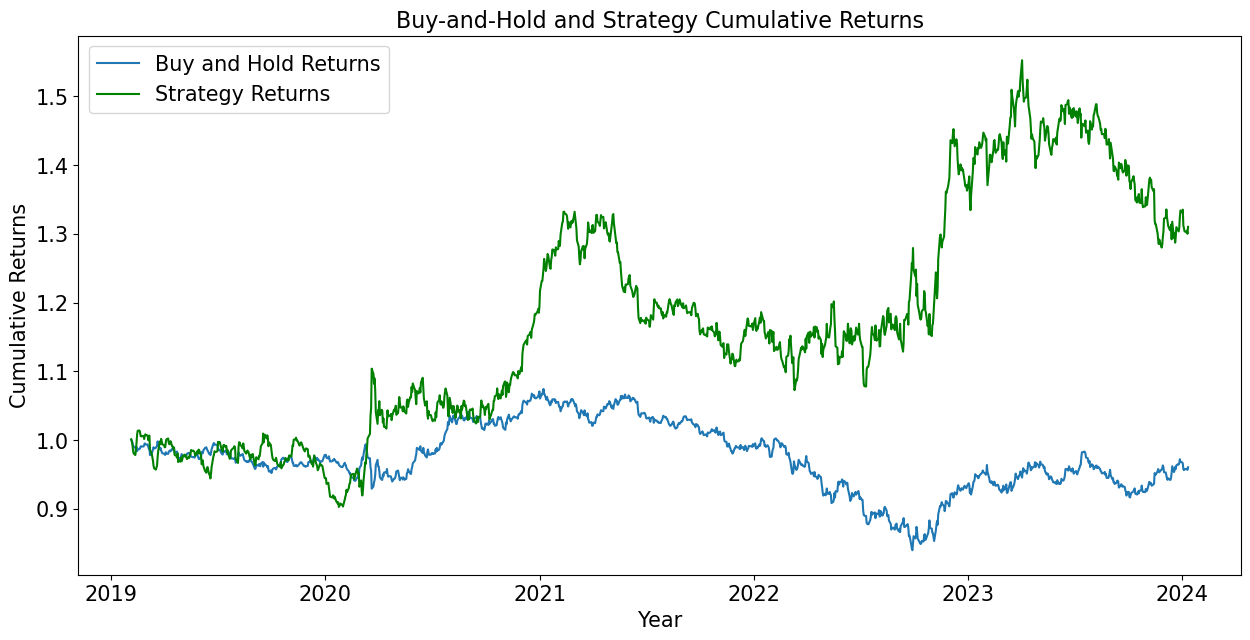

In [8]:
# Subset the data
plot_data = data.iloc[initial_iloc:]

# Buy and hold strategy cumulative returns
plot_data['buy_and_hold_cum_returns'] = (1+plot_data['returns']).cumprod()

# Strategy returns
plot_data['strategy_returns'] = plot_data['returns'] * plot_data['signal']

# Strategy cumulative returns
plot_data['strategy_cum_returns'] = (1+plot_data['strategy_returns']*2).cumprod()

# Set the figure size
plt.figure(figsize=(15,7))

# Plot both the Buy-and-hold, SMA and HMM-DC-based strategy cumulative returns
plt.plot(plot_data.index, plot_data['buy_and_hold_cum_returns'], label = "Buy and Hold Returns")
plt.plot(plot_data.index, plot_data['strategy_cum_returns'], label = "Strategy Returns", color='g')

# Set the title of the graph
plt.title('Buy-and-Hold and Strategy Cumulative Returns', fontsize=16)

# Set the x- and y- axis labels and ticks sizes
plt.xlabel('Year', fontsize=15)
plt.ylabel('Cumulative Returns', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

# Set the plot legend location
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))

plt.savefig('Figures/strategies_cum_returns.png', bbox_inches='tight')

Start date,2019-02-05
End date,2024-01-11
Total months,61
,Backtest
Annual return,5.43%
Cumulative returns,30.891%
Annual volatility,14.537%
Sharpe ratio,0.44
Calmar ratio,0.28
Stability,0.75
Max drawdown,-19.491%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.49,2021-02-11,2022-03-11,2022-11-23,465
1,17.56,2023-04-03,2023-11-27,NaT,NaN
2,10.97,2019-02-18,2020-01-24,2020-03-18,283
3,8.12,2022-12-07,2023-01-05,2023-03-13,69
4,7.91,2020-03-20,2020-04-14,2020-11-30,182


Stress Events,mean,min,max
New Normal,0.03%,-3.48%,5.55%


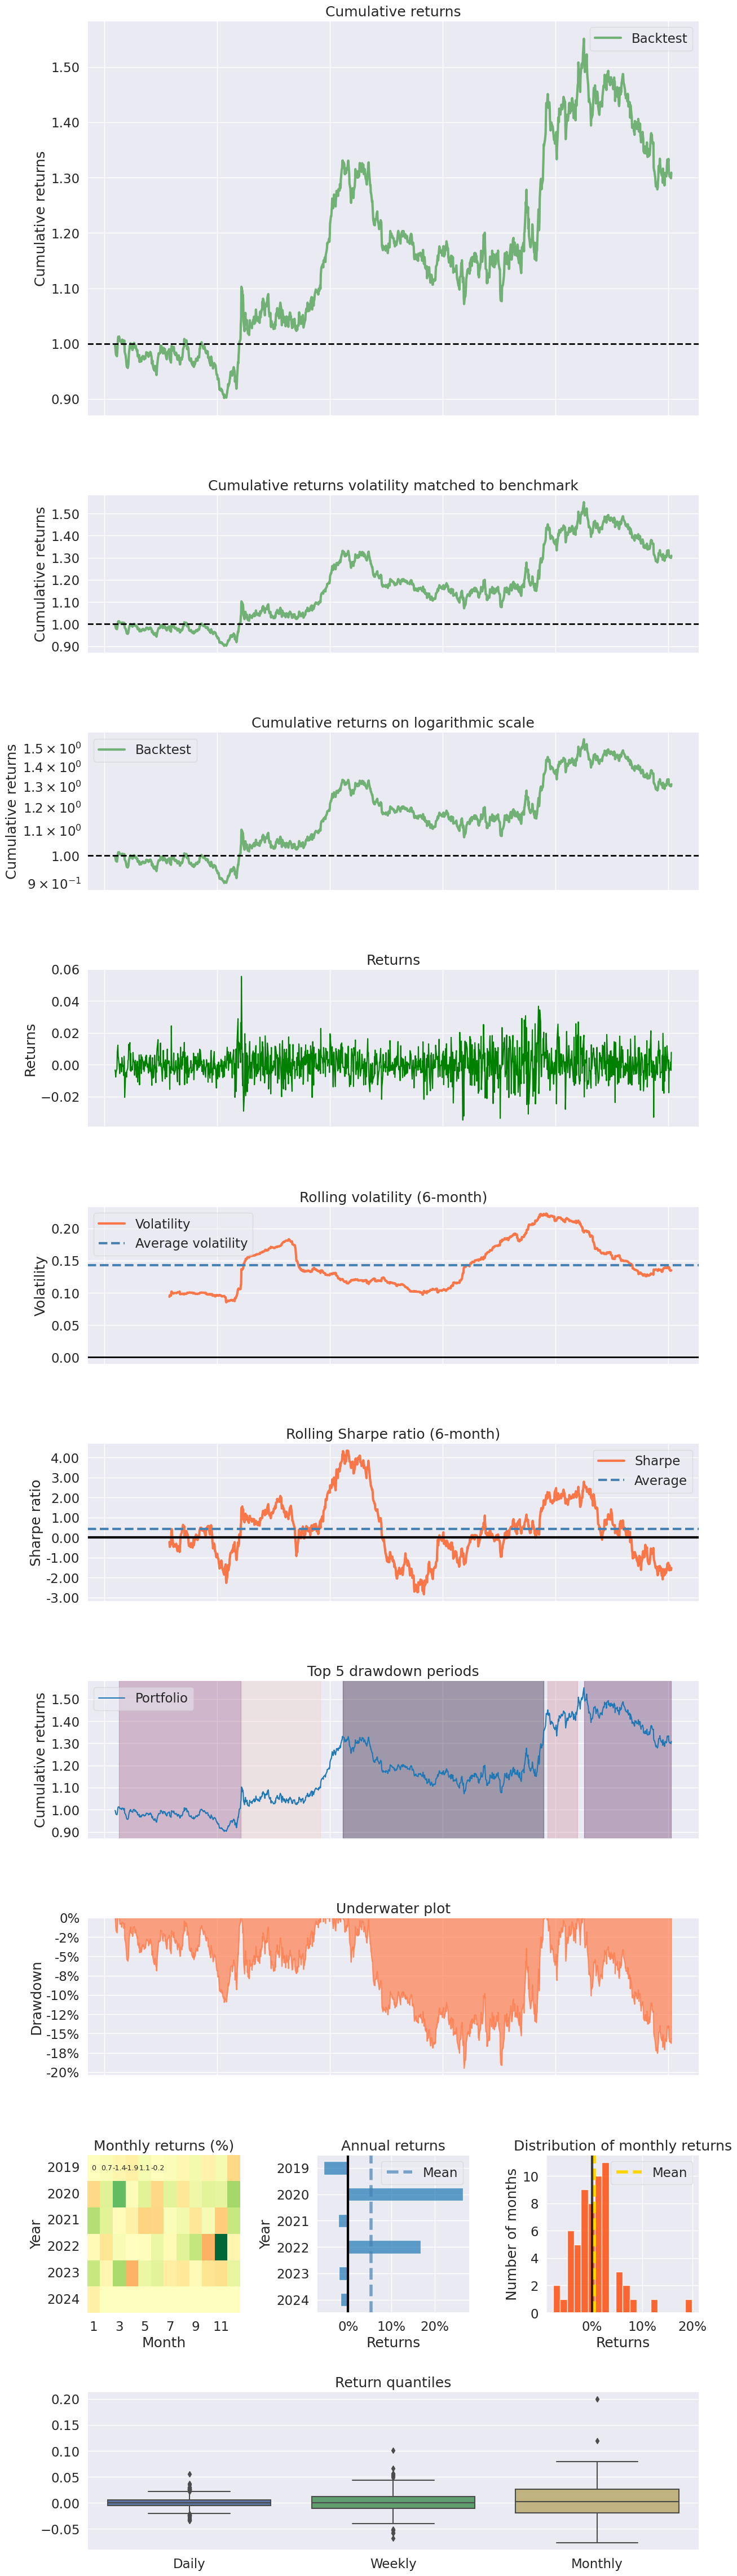

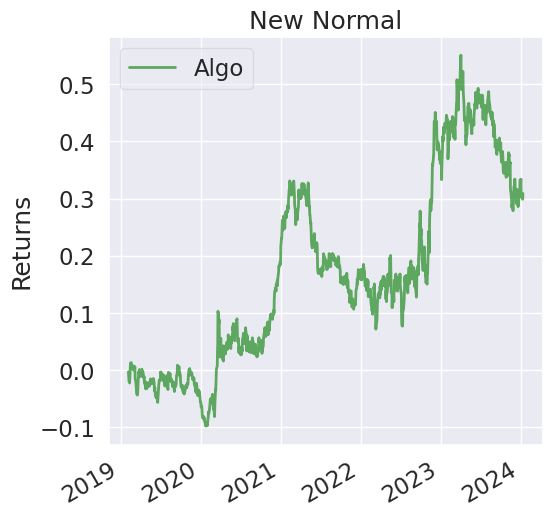

In [9]:
pf.create_full_tear_sheet(plot_data['strategy_cum_returns'].pct_change().dropna())

Start date,2019-02-05
End date,2024-01-11
Total months,61
,Backtest
Annual return,-0.8%
Cumulative returns,-4.006%
Annual volatility,7.271%
Sharpe ratio,-0.07
Calmar ratio,-0.04
Stability,0.18
Max drawdown,-21.839%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,21.84,2021-01-07,2022-09-28,NaT,NaN
1,6.96,2019-02-05,2020-03-20,2020-07-21,381
2,2.62,2020-08-19,2020-09-28,2020-11-30,74
3,1.18,2020-08-07,2020-08-12,2020-08-19,9
4,0.97,2020-12-31,2021-01-01,2021-01-06,5


Stress Events,mean,min,max
New Normal,-0.00%,-2.78%,1.84%


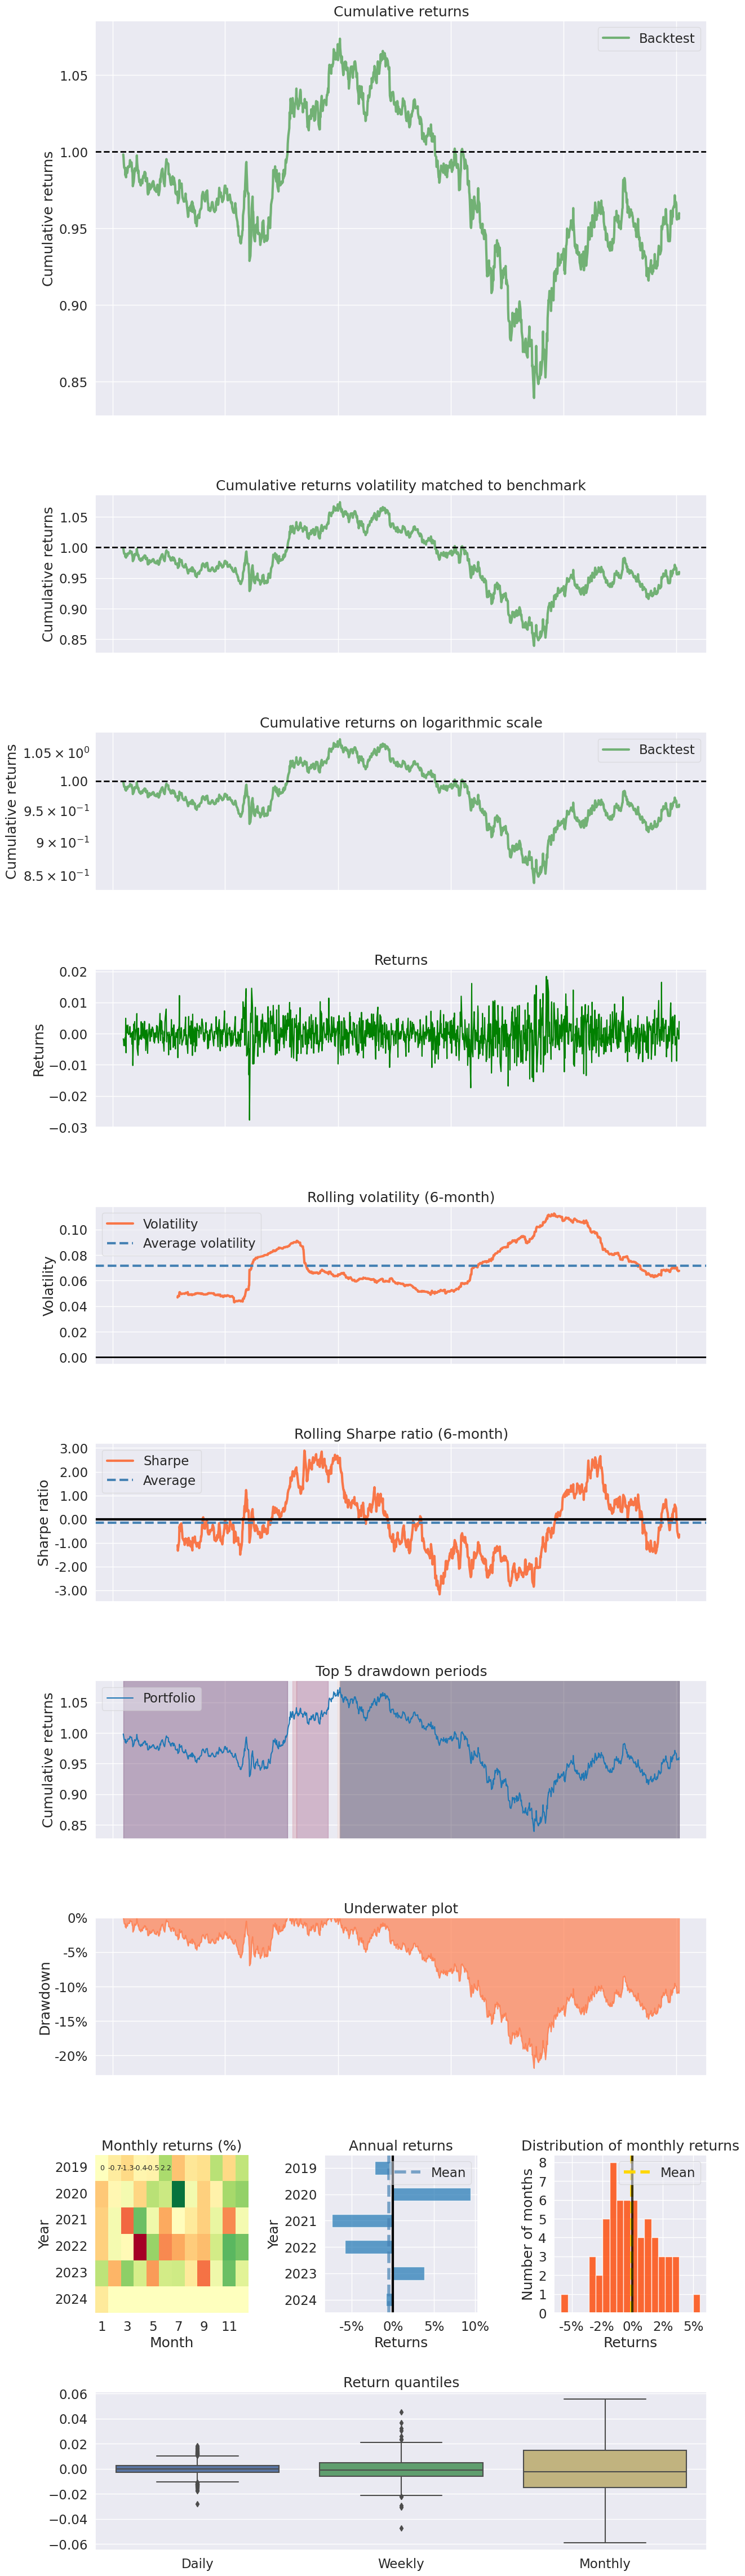

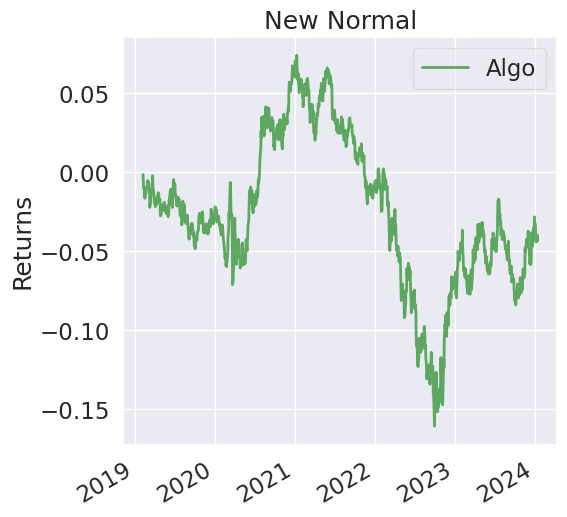

In [10]:
pf.create_full_tear_sheet(plot_data['buy_and_hold_cum_returns'].pct_change().dropna())